In [1]:
import numpy as np
import matplotlib.pyplot as plt
import holidays
import pandas as pd
%matplotlib inline

# Dataset olandese

Di seguito viene analizzato un dataset contenente campionamenti dei consumi elettrici di un
determinato ufficio in Olanda durante l'anno 1997.

In [2]:
plt.rcParams["figure.figsize"] = (24,16)
with open('power_data_eamonn-1.txt', 'r') as f:
    x = f.readlines()
#x
x = np.array([int(i) for i in x if i != '\n'])
print(len(x), x)
DAY = 96

35040 [950 939 943 ... 627 633 882]


Il numero di campioni rilevati è pari 35040 che diviso per il numero di giorni in un anno(365) e
per il numero di ore in un giorno(24) si ottiene il valore 4: si può ipotizzare che la frequenza campionaria è di 15 minuti
e che quindi il numero di campioni giornalieri sia pari a 96.
Plottando i dati è possibile verificare se effettivamente questa ipotesi possa essere valida.

Di seguito vengono effettuate le medie di ciascuna finestra da 96 campioni, ovvero i presunti consumi medi giornalieri e
vengono mostrati in sovrapposizione i campioni dei primi due ipotetici mesi e l'istogramma dei consumi giornalieri medi.
Imponendo che la larghezza di un blocco appartenente all'istogramma sia largo quanto la distanza tra 96 campioni si può
verificare facilmente per via grafica che l'ipotesi fatta è perfettamente sensata.

In [3]:
x_day = np.mean(np.vstack([x[i*DAY:(i+1)*DAY] for i in range(len(x)//DAY)]), axis=1)
x_day.shape

(365,)

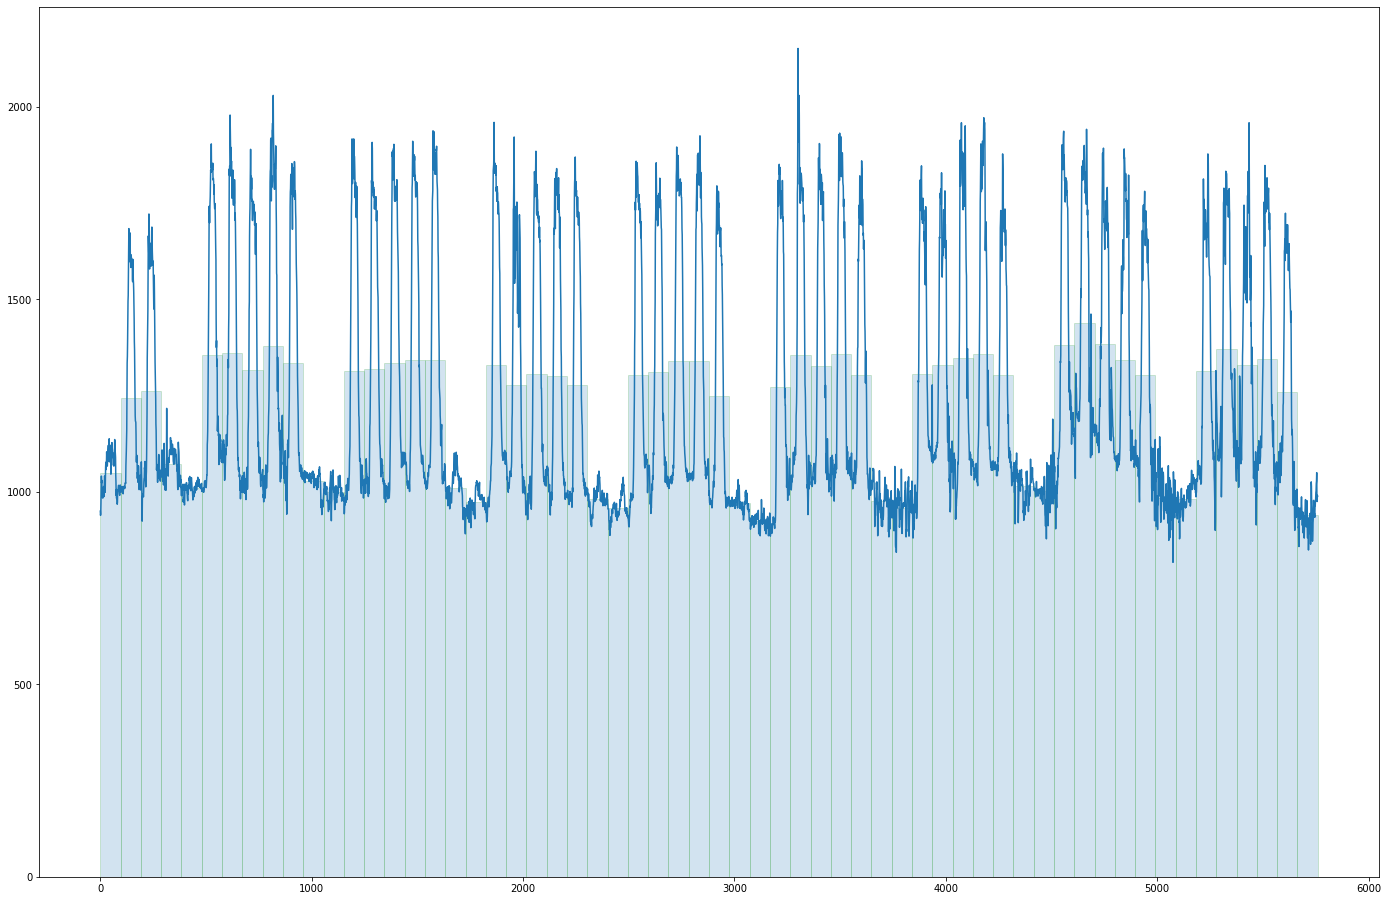

In [4]:
plt.close()
plt.plot(x[:DAY*60])
plt.bar(np.arange(0, DAY*60, DAY) + DAY/2, x_day[:60], width=DAY, alpha=0.2, edgecolor='C2')
plt.show()
# plt.savefig('a.svg')

Dalla morfologia del grafico è anche facile individuare quale giorno della settimana associare a ciascuna finestra da 96 campioni,
infatti è facile verificare visivamente che il primo giorno dell'anno è un mercoledì.

Sapendo ciò è possibile associare ad ogni finestra un determinato giorno della settimana in maniera automatica: di seguito
vengono raccolte tutte le finestre contenenti giorni del weekend nell'insieme 'holi'.


In [5]:
holi = set()
for idx, a in enumerate(x_day):
    if (idx+2) % 7 > 4:
       holi.add(idx)


Infine vengono cercate tutte le finestre dei campioni raccolti durante i giorni festivi e aggiunte all'insieme 'holi'.

In [6]:
holidays_netherlands = holidays.CountryHoliday('Netherlands')
holi_array = []

YEAR = 1997
for d in pd.date_range(start=f'01-01-{YEAR}', end=f'31-12-{YEAR}', freq='1D'):
    if d in holidays_netherlands:
        print(d, holidays_netherlands.get(d), d.dayofyear)
        holi.add(d.dayofyear - 1)
for number in holi:
    holi_array.append(number)
holi = np.array(holi_array)


1997-01-01 00:00:00 Nieuwjaarsdag 1
1997-03-28 00:00:00 Goede Vrijdag 87
1997-03-30 00:00:00 Eerste paasdag 89
1997-03-31 00:00:00 Tweede paasdag 90
1997-04-30 00:00:00 Koninginnedag 120
1997-05-08 00:00:00 Hemelvaart 128
1997-05-18 00:00:00 Eerste Pinksterdag 138
1997-05-19 00:00:00 Tweede Pinksterdag 139
1997-12-25 00:00:00 Eerste Kerstdag 359
1997-12-26 00:00:00 Tweede Kerstdag 360


Una volta fatto ciò è possibile rappresentare tramite degli istogrammi blu la media dei consumi di ciascuna finestra e nel caso
in cui questi consumi appartenessero alle finestre di 'holi', questi verranno sovrapposti con un istogramma rosso.
Facendo ciò, è facile individuare i giorni anomali.


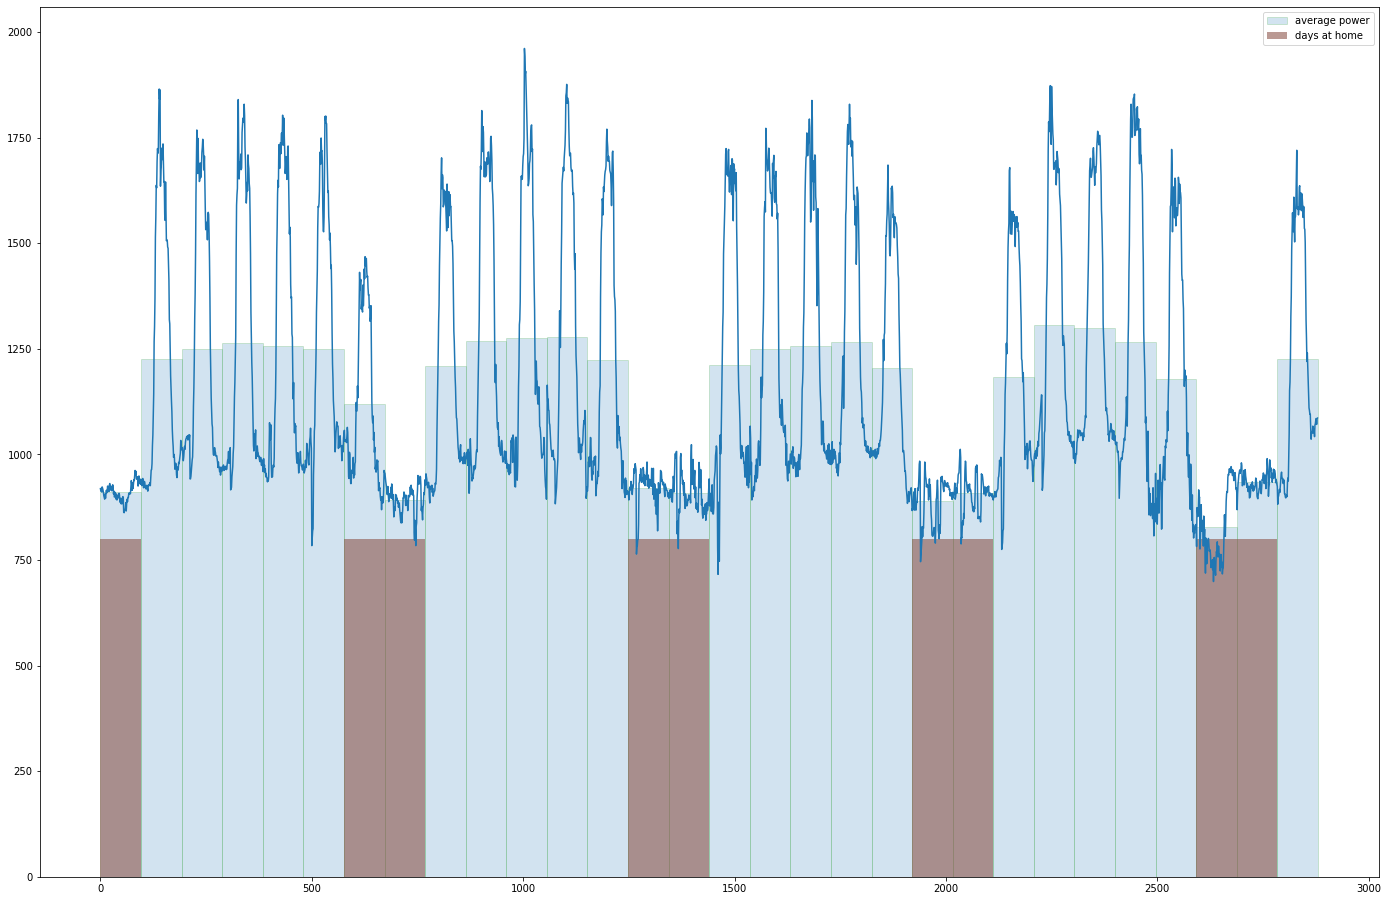

In [10]:
def findIndex(array, LIM, comparator):
    index = 0
    for element in array:
        if comparator(element, LIM):
            return index
        else:
            index += 1
    return index

LIML = 270
LIMR = 300

holi_right = findIndex(holi, LIMR, (lambda x, y: x >= y))
holi_left = findIndex(holi, LIML, (lambda x, y: x >= y))

plt.close()
plt.plot(x[DAY*LIML:DAY*LIMR])
plt.bar(np.arange(0, DAY*(LIMR-LIML), DAY) + DAY/2, x_day[LIML:LIMR], width=DAY, alpha=0.2, edgecolor='C2', label="average power")

plt.bar((holi[holi_left : holi_right] - LIML) * DAY + DAY/2, 800, width=DAY, alpha=0.6, color='C5', label="days at home")
plt.legend()
plt.show()


Di seguito, dato il numero(a partire da 0) associato ad uno degli istogrammi rappresentati è possibile ottenere la data
corrispondente, in questo modo è possibile determinare quali sono i giorni anomali a partire dal blocco considerato.


In [9]:
number_from_histogram = 6 + LIML
datesOfSample = [date for date in pd.date_range(start=f'01-01-{YEAR}', end=f'31-12-{YEAR}', freq='1D')]
print(datesOfSample[number_from_histogram])

1997-10-04 00:00:00


I giorni anomali individuati sono i seguenti:
- 1997-05-05 giorno lavorativo con consumi bassi.
- 1997-10-04 giorno festivo con consumi alti.